# Simulation - Sparsity in High Dimensions

Number of samples M = 500



[tensor(0.0010), tensor(0.1678), tensor(4.5150), tensor(15.8764), tensor(30.5541), tensor(47.3833), tensor(56.9779), tensor(64.4709), tensor(70.0417), tensor(73.7418), tensor(76.3904), tensor(78.5091), tensor(79.8544), tensor(80.8670)]


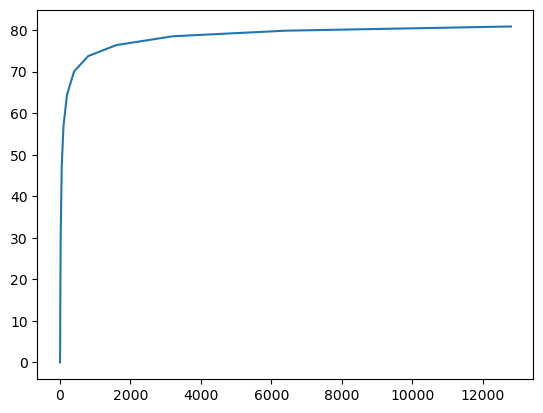

In [55]:
import numpy as np
import torch
import matplotlib.pyplot as plt


m = 500
n = [1, 2, 5, 10, 20, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800]
MeanNNDistance = []

for dim in n:
    # Creates a tensor of (m x ni)
    Dataset = torch.rand(m, dim)

    # (1 x m x n) - (m x 1 x n) broadcasting will make it (m x m x n)
    diffs = Dataset[:, None, :] - Dataset[None, :, :]

    # Calculate squared euclidean distance
    EucDist = torch.sum(diffs**2, axis=2)

    # Gets smallest 2 euclidean distances for each point
    top2_values, top2_indices = torch.topk(EucDist, k=2, dim=1, largest=False)

    # Calculates Average mean nearest neighbor distance
    MeanNNDistance.append(torch.sum(top2_values) / dim)

print(MeanNNDistance)

xpoints = n
ypoints = MeanNNDistance
 
plt.plot(xpoints, ypoints)
plt.show()

In [45]:
m = 3
dim = 2


Dataset = torch.randint(low=1, high=10, size=(m,dim))

    # (1 x m x n) - (m x 1 x n) broadcasting will make it (m x m x n)
diffs = Dataset[:, None, :] - Dataset[None, :, :]

    # Calculate squared euclidean distance
EucDist = torch.sum(diffs**2, dim=2)

top2_values, top2_indices = torch.topk(EucDist, k=2, dim=1, largest=False)

MeanNNDistance = torch.sum(top2_values) / dim

print(Dataset)
print(diffs)
print(EucDist)
print(top2_values)
print(MeanNNDistance)

tensor([[7, 8],
        [9, 9],
        [7, 1]])
tensor([[[ 0,  0],
         [-2, -1],
         [ 0,  7]],

        [[ 2,  1],
         [ 0,  0],
         [ 2,  8]],

        [[ 0, -7],
         [-2, -8],
         [ 0,  0]]])
tensor([[ 0,  5, 49],
        [ 5,  0, 68],
        [49, 68,  0]])
tensor([[ 0,  5],
        [ 0,  5],
        [ 0, 49]])
tensor(29.5000)
